## Week 1 Homework

What we have learned in week 1 would be implemented to this homework with the purpose of experiencing hands-on data analysis, preprocessing, modelling and prediction on much similar problem, For-Hire Vehicle Trip Records.

In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import os
from pathlib import Path

In [2]:
PATH_CUR = os.getcwd()
p = Path(PATH_CUR)
p.parents[0]

WindowsPath('D:/github_repos/MLOps')

## Q1. Downloading the data

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

In [72]:
df_hw = pd.read_parquet(os.path.join(p.parents[0], 'data/fhv_tripdata_2021-01.parquet'))
df_hw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [156]:
len(df_hw)

1154112

### Answer : 1154112 rows

In [157]:
df_hw.head(10)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000
6,B00037,2021-01-01 00:18:12,2021-01-01 00:30:04,NaN,91.0,None,B00037,11.866667
7,B00037,2021-01-01 00:36:15,2021-01-01 00:45:08,NaN,39.0,None,B00037,8.883333
8,B00037,2021-01-01 00:55:04,2021-01-01 01:13:02,NaN,37.0,None,B00037,17.966667
9,B00037,2021-01-01 00:48:40,2021-01-01 01:12:02,NaN,39.0,None,B00037,23.366667


In [74]:
df_hw.iloc[0]['dropOff_datetime'] - df_hw.iloc[0]['pickup_datetime']

Timedelta('0 days 00:17:00')

In [75]:
df_hw.iloc[1]['dropOff_datetime'] - df_hw.iloc[1]['pickup_datetime']

Timedelta('0 days 00:17:00')

In [76]:
df_hw.iloc[2]['dropOff_datetime'] - df_hw.iloc[2]['pickup_datetime']

Timedelta('0 days 01:50:00')

## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [77]:
df_hw['duration'] = df_hw.dropOff_datetime - df_hw.pickup_datetime
df_hw[['duration']].head()

,duration
0,0 days 00:17:00
1,0 days 00:17:00
2,0 days 01:50:00
3,0 days 00:08:17
4,0 days 00:15:13


In [78]:
df_hw.duration = df_hw.duration.apply(lambda td: td.total_seconds() / 60)
df_hw[['duration']].head()

,duration
0,17.000000
1,17.000000
2,110.000000
3,8.283333
4,15.216667


In [79]:
df_hw.duration.describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

### Answer: 19.16

## Data Preparation
Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop? 

In [113]:
df_hw_filt = df_hw[(df_hw.duration >= 1) & (df_hw.duration <= 60)]

In [114]:
print(f'Records removed after filtering is {len(df_hw) - len(df_hw_filt)} rows.')

Records removed after filtering is 44286 rows.


### Answer: 44286 records

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


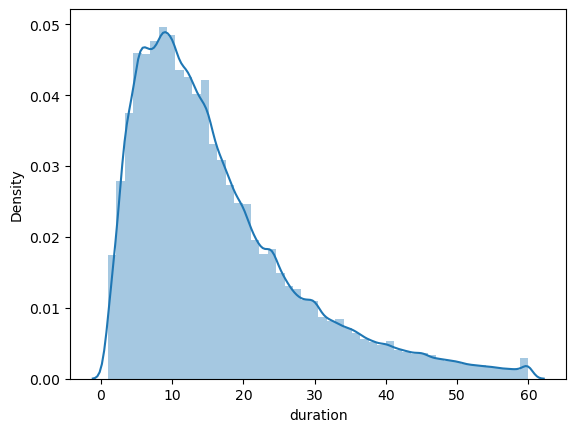

In [82]:
import seaborn as sns

sns.distplot(df_hw_filt.duration)
plt.show()

## Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [115]:
print(f'Missing values fraction on the pickup location ID: {100*df_hw_filt.PUlocationID.isna().sum()/len(df_hw_filt):.2f}%')
print(f'Missing values fraction on the dropoff location ID: {100*df_hw_filt.DOlocationID.isna().sum()/len(df_hw_filt):.2f}%')

Missing values fraction on the pickup location ID: 83.53%
Missing values fraction on the dropoff location ID: 13.33%


### Answer: 83.53%

In [116]:
## Fillna with value "-1"
df_hw_filt.PUlocationID = df_hw_filt.PUlocationID.fillna(-1)
df_hw_filt.DOlocationID = df_hw_filt.DOlocationID.fillna(-1)

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [117]:
print(f'Missing values fraction on the pickup location ID: {100*df_hw_filt.PUlocationID.isna().sum()/len(df_hw_filt):.2f}%')
print(f'Missing values fraction on the dropoff location ID: {100*df_hw_filt.DOlocationID.isna().sum()/len(df_hw_filt):.2f}%')

Missing values fraction on the pickup location ID: 0.00%
Missing values fraction on the dropoff location ID: 0.00%


In [118]:
df_hw_filt['PUlocationID'].value_counts().nlargest(2)

-1.0      927008
 221.0      8330
Name: PUlocationID, dtype: int64

### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns)

In [119]:
from sklearn.feature_extraction import DictVectorizer

categorical = ['PUlocationID', 'DOlocationID']
# numerical = ['trip_distance']

df_hw_filt[categorical] = df_hw_filt[categorical].astype(str)

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [120]:
df_hw_filt.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [121]:
df_hw_filt[categorical].iloc[:7].to_dict(orient='records')

[{'PUlocationID': '-1.0', 'DOlocationID': '-1.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '-1.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '72.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '61.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '71.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '91.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '39.0'}]

In [145]:
train_dicts = df_hw_filt[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [146]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [158]:
X_train.shape[1]

525

### Answer: 525

### Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [148]:
target = 'duration'
y_train = df_hw_filt[target].values

In [149]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

error_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'RMSE: {error_rmse}')

RMSE: 10.528519107223724


### Answer: 10.52

### Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

In [136]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df_hw = pd.read_csv(filename)
    elif filename.endswith('.parquet'):
        df_hw = pd.read_parquet(filename)
    
    df_hw['duration'] = df_hw.dropOff_datetime - df_hw.pickup_datetime
    df_hw.duration = df_hw.duration.apply(lambda td: td.total_seconds() / 60)
    df_hw = df_hw[(df_hw.duration >= 1) & (df_hw.duration <= 60)]
    df_hw.PUlocationID = df_hw.PUlocationID.fillna(-1)
    df_hw.DOlocationID = df_hw.DOlocationID.fillna(-1)
    categorical = ['PUlocationID', 'DOlocationID']
    df_hw[categorical] = df_hw[categorical].astype(str)
    
    return df_hw

In [137]:
df_val = read_dataframe(os.path.join(p.parents[0], 'data/fhv_tripdata_2021-02.parquet'))
df_val.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1.0,225.0,None,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1.0,61.0,None,B00037,8.966667


In [139]:
df_val.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [159]:
del X_val, y_val, lr_val, y_pred_val

In [160]:
df_val.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1.0,225.0,None,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1.0,61.0,None,B00037,8.966667


In [161]:
categorical = ['PUlocationID', 'DOlocationID']
val_dicts = df_val[categorical].to_dict(orient='records')

# dv_val = DictVectorizer()
X_val = dv.transform(val_dicts)

In [162]:
X_val.shape

(990113, 525)

In [163]:
target = 'duration'
y_val = df_val[target].values

In [164]:
y_val.shape

(990113,)

In [165]:
y_pred_val = lr.predict(X_val)

error_rmse = mean_squared_error(y_val, y_pred_val, squared=False)
print(f'RMSE: {error_rmse}')

RMSE: 11.01428321783417


### Answer: 11.01